In [ ]:
# Import the necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
plt.style.use('seaborn')

import pandas as pd
import numpy as np

### Play-Play Network

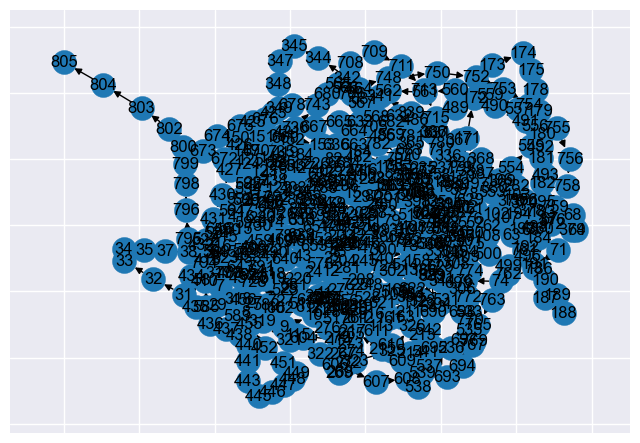

In [ ]:
from nba_api.stats.endpoints import playbyplayv2

# Call the API to get the play-by-play data
game_id = '0021900001' # Replace with the actual game ID you want to analyze
play_by_play = playbyplayv2.PlayByPlayV2(game_id=game_id)
play_by_play_df = play_by_play.get_data_frames()[0]

# Build the network
G = nx.DiGraph()

# Creating the nodes
for index, row in play_by_play_df.iterrows():
    G.add_node(row['EVENTNUM'], play_name=row['EVENTMSGTYPE'])

# Creating the edges
for index, row in play_by_play_df.iterrows():
    if index != 0:
        G.add_edge(play_by_play_df.loc[index-1, 'EVENTNUM'], row['EVENTNUM'])

# Set the positions of the nodes
pos = nx.spring_layout(G, iterations=50, scale=2)

nx.draw_networkx(G, pos)
plt.show()


This code uses the playbyplayv2 endpoint of the nba_api package to retrieve the play-by-play data for a specific game, then it creates a directed graph, where nodes are the plays and edges are the sequence of events that lead to a successful play, with the edges pointing from the event that leads to a play to the play itself.

You can also use this graph for further analysis like finding centrality measures, communities, etc.

### player-play network

In [ ]:
!pip install networkx

MovieWriter imagemagick unavailable; using Pillow instead.
c:\Users\baigs\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:462: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


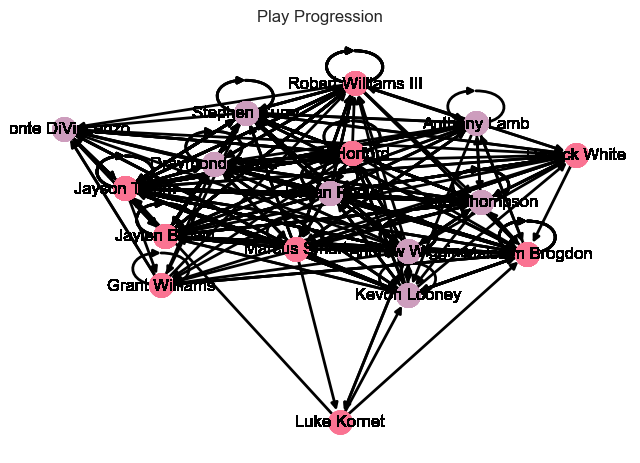

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from nba_api.stats.endpoints import playbyplayv2
# Call the API to get the play-by-play data
game_id = '0022200679' # Replace with the actual game ID you want to analyze
play_by_play = playbyplayv2.PlayByPlayV2(game_id=game_id)

# Remove rows with null values from the player-play network dataframe
play_by_play_df = play_by_play_df[play_by_play_df['PLAYER1_NAME'].notnull() & play_by_play_df['PLAYER1_TEAM_ID'].notnull()]

# Create the graph
G = nx.DiGraph()

# Define a list of players
list_of_players = list(set(play_by_play_df['PLAYER1_NAME'].values))

# Define a list of teams
list_of_teams = list(set(play_by_play_df['PLAYER1_TEAM_ID'].values))

# Create a dictionary to store the colors for each team
team_colors = {team:np.random.rand(3) for team in list_of_teams}

# Add the edges to the graph
for i, row in play_by_play_df.iterrows():
    if i > 0:
        if row["PLAYER1_NAME"] in list_of_players and row["prev_player_name"] in list_of_players:
            G.add_edge(row["prev_player_name"], row["PLAYER1_NAME"], event_type=row['EVENTMSGTYPE'])
    if row["PLAYER1_NAME"] in list_of_players:
        G.add_node(row["PLAYER1_NAME"], event_type=row['EVENTMSGTYPE'], team_id = row['PLAYER1_TEAM_ID'])

# Set the layout
pos = nx.spring_layout(G)

# Create the animation
fig = plt.figure()

def update(num):
    edges_to_draw = []
    nodes_to_draw = []
    if num > 0:
        row = play_by_play_df.iloc[num]
        if row["PLAYER1_NAME"] in list_of_players and row["prev_player_name"] in list_of_players:
            G.add_edge(row["prev_player_name"], row["PLAYER1_NAME"], event_type=row['EVENTMSGTYPE'])
            edges_to_draw.append((row["prev_player_name"], row["PLAYER1_NAME"]))
    if num < play_by_play_df.shape[0]:
        row = play_by_play_df.iloc[num]
        if row["PLAYER1_NAME"] in list_of_players:
            G.add_node(row["PLAYER1_NAME"], event_type=row['EVENTMSGTYPE'], team_id = row['PLAYER1_TEAM_ID'])
            nodes_to_draw.append(row["PLAYER1_NAME"])
    if num == 0:
        plt.clf()
    else:
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_to_draw, node_color=[team_colors[nx.get_node_attributes(G, 'team_id')[node]] for node in nodes_to_draw], cmap='rainbow')
        nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, width=2)
        nx.draw_networkx_labels(G, pos, labels={node:node for node in G.nodes()})
    plt.title("Play Progression")
    plt.axis('off')

ani = FuncAnimation(fig, update, frames=range(play_by_play_df.shape[0]), repeat=False)
ani.save('../Results/Animation/animation2.gif', writer='imagemagick')

plt.show()





In [ ]:
from nba_api.stats.endpoints import playbyplayv2
game_id = '0022200679' # Replace with the actual game ID you want to analyze
play_by_play = playbyplayv2.PlayByPlayV2(game_id=game_id)
play_by_play = play_by_play.get_data_frames()


In [ ]:
play_by_play[0].columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

# Synergy Analysis of NBA Super Star LeBron James


In [ ]:
from random import choice
import networkx as nx
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import playergamelog

In [ ]:
# Get Lebron James' player ID
lebron = players.find_players_by_full_name("LeBron James")[0]
lebron_id = lebron["id"]

In [ ]:
# Get Lebron James' game logs for a given season
game_logs = playergamelog.PlayerGameLog(player_id=lebron_id).get_data_frames()
game_logs = game_logs[0]
game_ids = game_logs.Game_ID.unique()  

In [ ]:
len(game_ids)

37

In [ ]:
# Get the play-by-play data for all games Lebron James played in
plays = pd.DataFrame()
for game in game_ids:
    # try:
        play_by_play = playbyplayv2.PlayByPlayV2(game_id=game)
        play = play_by_play.get_data_frames()[0]
        plays = plays.append(play)
        print(f"Shape : {plays.shape}")

    # except:
    #     print(f"Failed for {game}")

plays.head()

In [ ]:
plays[(plays['PLAYER1_ID']==lebron_id)&(plays['EVENTMSGTYPE']==1)]

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
2,0022200705,7,1,108,1,9:15 PM,11:47,None,None,James 1' Cutting Dunk Shot (2 PTS) (Schroder 1...,...,Lakers,LAL,0,0,None,NaN,None,None,None,1
10,0022200705,18,1,103,1,9:16 PM,10:27,None,None,James 29' 3PT Running Pull-Up Jump Shot (5 PTS),...,None,None,0,0,None,NaN,None,None,None,1
13,0022200705,21,1,103,1,9:16 PM,9:58,None,None,James 30' 3PT Running Pull-Up Jump Shot (8 PTS),...,None,None,0,0,None,NaN,None,None,None,1
33,0022200705,48,1,63,1,9:23 PM,7:15,None,None,James 17' Fadeaway Jumper (10 PTS),...,None,None,0,0,None,NaN,None,None,None,1
89,0022200705,131,1,83,1,9:37 PM,0:40,None,None,James 14' Fadeaway Bank Shot (12 PTS),...,None,None,0,0,None,NaN,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0022200095,390,1,6,3,10:57 PM,11:01,James 1' Driving Layup (13 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
268,0022200095,396,1,6,3,10:58 PM,10:00,James 2' Driving Layup (15 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
285,0022200095,421,1,1,3,11:01 PM,8:24,James 16' Jump Shot (18 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
394,0022200095,574,1,79,4,11:30 PM,8:22,James 26' 3PT Pullup Jump Shot (22 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:
# Create the graph
G = nx.DiGraph()

In [ ]:
# Create a dictionary to store the number of passes between Lebron and each teammate
synergy_metrics = {}

# Iterate through the play-by-play data
for i, play in plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        if play['PLAYER1_ID'] == lebron_id: # check if Lebron was the shooter
            shooter_name = play['PLAYER1_NAME']
            shooter_team_id = play['PLAYER1_TEAM_ID']
            if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
                assist_name = play['PLAYER2_NAME']
                assist_team_id = play['PLAYER2_TEAM_ID']
                if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team
                    if assist_name not in synergy_metrics:
                        synergy_metrics[assist_name] = 1
                    else:
                        synergy_metrics[assist_name] += 1
                        

In [ ]:
synergy_metrics

{'Dennis Schroder': 30,
 'Patrick Beverley': 11,
 'Russell Westbrook': 55,
 'Thomas Bryant': 11,
 'Troy Brown Jr.': 5,
 'Kendrick Nunn': 2,
 'Juan Toscano-Anderson': 2,
 'Wenyen Gabriel': 4,
 'Austin Reaves': 18,
 'Lonnie Walker IV': 6,
 'Anthony Davis': 22,
 'Matt Ryan': 1}

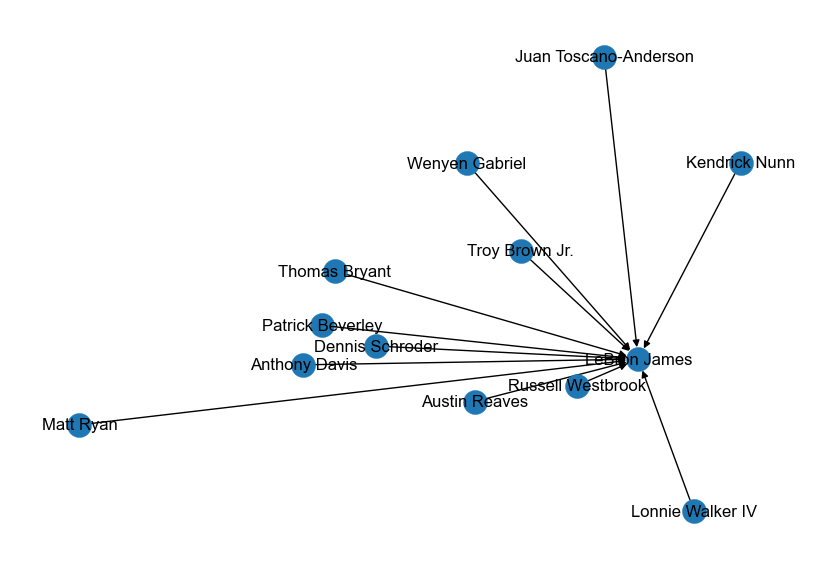

In [ ]:
# Add nodes and edges to the graph
for teammate, passes in synergy_metrics.items():
    G.add_node(teammate)
    G.add_edge(teammate,shooter_name, weight=passes)
    
# Draw the graph
nx.draw(G, with_labels=True)


In [ ]:
# Save the team affiliation network to csv
nx.write_weighted_edgelist(G, 'lebron_synergy_edgelist.csv', delimiter=',', encoding='utf-8')

# Synergy Curry

In [ ]:
#!pip install nba_api

In [ ]:
from random import choice
import networkx as nx
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import playergamelog

In [ ]:
# Get Lebron James' player ID
Curry = players.find_players_by_full_name("Stephen Curry")[0]
Curry_id = Curry["id"]

In [ ]:
# Get Lebron James' game logs for a given season
game_logs = playergamelog.PlayerGameLog(player_id=Curry_id).get_data_frames()
game_logs = game_logs[0]
game_ids = game_logs.Game_ID.unique()  
game_logs.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22022,201939,0022200704,"JAN 22, 2023",GSW vs. BKN,L,38,7,16,0.438,...,5,6,7,1,0,5,2,26,-8,1
1,22022,201939,0022200679,"JAN 19, 2023",GSW @ BOS,L,43,9,25,0.360,...,4,4,7,3,2,3,1,29,9,1
2,22022,201939,0022200660,"JAN 16, 2023",GSW @ WAS,W,38,12,28,0.429,...,6,7,2,0,0,4,1,41,14,1
3,22022,201939,0022200650,"JAN 15, 2023",GSW @ CHI,L,34,8,15,0.533,...,10,10,4,0,1,8,2,20,-9,1
4,22022,201939,0022200635,"JAN 13, 2023",GSW @ SAS,W,23,6,12,0.500,...,4,4,3,0,1,0,3,15,12,1


In [ ]:
game_logs.columns


Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [ ]:
# Get the play-by-play data for all games Lebron James played in
plays = pd.DataFrame()
for game in game_ids:
    # try:
        play_by_play = playbyplayv2.PlayByPlayV2(game_id=game)
        play = play_by_play.get_data_frames()[0]
        plays = plays.append(play)
        print(f"Shape : {plays.shape}")

    # except:
    #     print(f"Failed for {game}")

plays.head()

Shape : (485, 34)
Shape : (1034, 34)
Shape : (1485, 34)
Shape : (1960, 34)
Shape : (2462, 34)
Shape : (2987, 34)
Shape : (3468, 34)
Shape : (3961, 34)
Shape : (4425, 34)
Shape : (4892, 34)
Shape : (5338, 34)
Shape : (5832, 34)
Shape : (6328, 34)
Shape : (6803, 34)
Shape : (7255, 34)
Shape : (7726, 34)
Shape : (8179, 34)
Shape : (8681, 34)
Shape : (9151, 34)
Shape : (9627, 34)
Shape : (10092, 34)
Shape : (10574, 34)
Shape : (11065, 34)
Shape : (11570, 34)
Shape : (12028, 34)
Shape : (12523, 34)
Shape : (13046, 34)
Shape : (13490, 34)
Shape : (13995, 34)
Shape : (14511, 34)
Shape : (14989, 34)
Shape : (15515, 34)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200704,2,12,0,1,8:42 PM,12:00,None,Start of 1st Period (8:42 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200704,4,10,0,1,8:42 PM,12:00,Jump Ball D. Green vs. Claxton: Tip to Irving,None,None,...,Nets,BKN,5,202681,Kyrie Irving,1.610613e+09,Brooklyn,Nets,BKN,1
2,0022200704,7,1,108,1,8:42 PM,11:37,None,None,Claxton 5' Cutting Dunk Shot (2 PTS) (Irving 1...,...,Nets,BKN,0,0,None,NaN,None,None,None,1
3,0022200704,9,2,79,1,8:42 PM,11:21,MISS Poole 18' Pullup Jump Shot,None,None,...,None,None,0,0,None,NaN,None,None,None,1
4,0022200704,10,4,0,1,8:42 PM,11:19,None,None,Claxton REBOUND (Off:0 Def:1),...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:
# Create the graph
G = nx.DiGraph()

In [ ]:
# Create a dictionary to store the number of passes between Lebron and each teammate
synergy_metrics = {}

# Iterate through the play-by-play data
for i, play in plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        if play['PLAYER1_ID'] == Curry_id: # check if Lebron was the shooter
            shooter_name = play['PLAYER1_NAME']
            shooter_team_id = play['PLAYER1_TEAM_ID']
            if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
                assist_name = play['PLAYER2_NAME']
                assist_team_id = play['PLAYER2_TEAM_ID']
                if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team
                    if assist_name not in synergy_metrics:
                        synergy_metrics[assist_name] = 1
                    else:
                        synergy_metrics[assist_name] += 1
                        

In [ ]:
synergy_metrics

{'Draymond Green': 64,
 'Anthony Lamb': 10,
 'Jordan Poole': 20,
 'Ty Jerome': 2,
 'Klay Thompson': 9,
 'Andrew Wiggins': 12,
 'Andre Iguodala': 2,
 'Kevon Looney': 15,
 'Jonathan Kuminga': 2,
 'JaMychal Green': 2,
 'Donte DiVincenzo': 6,
 'James Wiseman': 1}

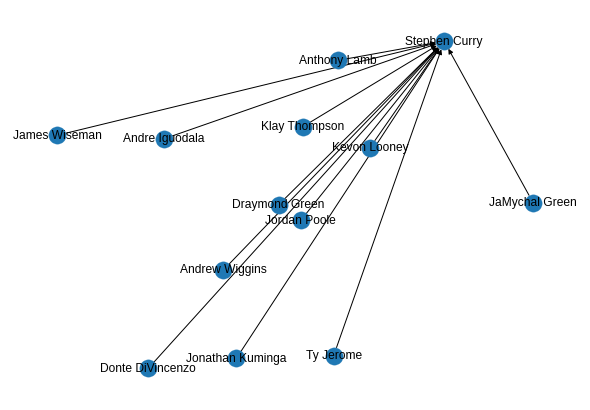

In [ ]:
# Add nodes and edges to the graph
for teammate, passes in synergy_metrics.items():
    G.add_node(teammate)
    G.add_edge(teammate,shooter_name, weight=passes)
    
# Draw the graph
nx.draw(G, with_labels=True)


In [ ]:
# Save the team affiliation network to csv
nx.write_weighted_edgelist(G, 'lebron_synergy_edgelist.csv', delimiter=',', encoding='utf-8')

# Tatum

In [ ]:
# Get Lebron James' player ID
Tatum = players.find_players_by_full_name("Jayson Tatum")[0]
Tatum_id = Tatum["id"]

In [ ]:
# Get Lebron James' game logs for a given season
game_logs = playergamelog.PlayerGameLog(player_id=Tatum_id).get_data_frames()
game_logs = game_logs[0]
game_ids = game_logs.Game_ID.unique()  

In [ ]:
# Get the play-by-play data for all games Lebron James played in
plays = pd.DataFrame()
for game in game_ids:
    # try:
        play_by_play = playbyplayv2.PlayByPlayV2(game_id=game)
        play = play_by_play.get_data_frames()[0]
        plays = plays.append(play)
        print(f"Shape : {plays.shape}")

    # except:
    #     print(f"Failed for {game}")

plays.head()

Shape : (429, 34)
Shape : (978, 34)
Shape : (1428, 34)
Shape : (1865, 34)
Shape : (2295, 34)
Shape : (2724, 34)
Shape : (3143, 34)
Shape : (3620, 34)
Shape : (4084, 34)
Shape : (4555, 34)
Shape : (4988, 34)
Shape : (5439, 34)
Shape : (5899, 34)
Shape : (6342, 34)
Shape : (6813, 34)
Shape : (7298, 34)
Shape : (7790, 34)
Shape : (8282, 34)
Shape : (8743, 34)
Shape : (9207, 34)
Shape : (9670, 34)
Shape : (10125, 34)
Shape : (10578, 34)
Shape : (11087, 34)
Shape : (11508, 34)
Shape : (11919, 34)
Shape : (12398, 34)
Shape : (12822, 34)
Shape : (13271, 34)
Shape : (13682, 34)
Shape : (14119, 34)
Shape : (14629, 34)
Shape : (15092, 34)
Shape : (15537, 34)
Shape : (16016, 34)
Shape : (16473, 34)
Shape : (16887, 34)
Shape : (17369, 34)
Shape : (17885, 34)
Shape : (18332, 34)
Shape : (18837, 34)
Shape : (19323, 34)
Shape : (19799, 34)
Shape : (20226, 34)
Shape : (20672, 34)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200707,2,12,0,1,7:11 PM,12:00,None,Start of 1st Period (7:11 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,1
1,0022200707,29,10,0,1,7:11 PM,12:00,Jump Ball Carter Jr. vs. Horford: Tip to Fultz,None,None,...,Celtics,BOS,4,1628365,Markelle Fultz,1.610613e+09,Orlando,Magic,ORL,1
2,0022200707,4,5,40,1,7:11 PM,11:44,Banchero Out of Bounds Lost Ball Turnover (P1.T1),None,None,...,None,None,1,0,None,NaN,None,None,None,1
3,0022200707,5,2,1,1,7:12 PM,11:17,None,None,MISS Horford 16' Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
4,0022200707,6,4,0,1,7:12 PM,11:14,Carter Jr. REBOUND (Off:0 Def:1),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:
# Create the graph
G = nx.DiGraph()

In [ ]:
# Create a dictionary to store the number of passes between Lebron and each teammate
synergy_metrics = {}

# Iterate through the play-by-play data
for i, play in plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        if play['PLAYER1_ID'] == Tatum_id: # check if Lebron was the shooter
            shooter_name = play['PLAYER1_NAME']
            shooter_team_id = play['PLAYER1_TEAM_ID']
            if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
                assist_name = play['PLAYER2_NAME']
                assist_team_id = play['PLAYER2_TEAM_ID']
                if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team
                    if assist_name not in synergy_metrics:
                        synergy_metrics[assist_name] = 1
                    else:
                        synergy_metrics[assist_name] += 1
                        

In [ ]:
synergy_metrics

{'Grant Williams': 22,
 'Al Horford': 25,
 'Payton Pritchard': 4,
 'Derrick White': 47,
 'Malcolm Brogdon': 29,
 'Marcus Smart': 88,
 'Robert Williams III': 10,
 'Jaylen Brown': 31,
 'Luke Kornet': 7,
 'Blake Griffin': 5,
 'Sam Hauser': 2}

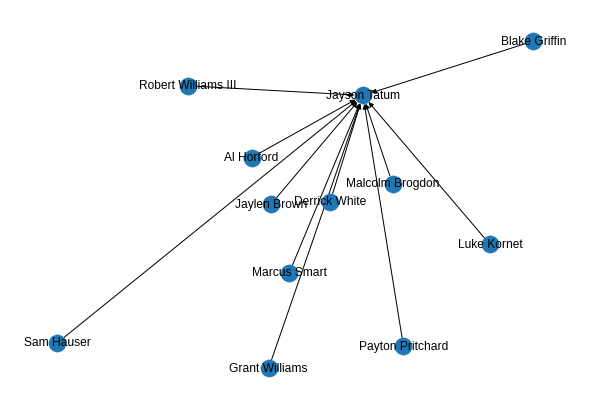

In [ ]:
# Add nodes and edges to the graph
for teammate, passes in synergy_metrics.items():
    G.add_node(teammate)
    G.add_edge(teammate,shooter_name, weight=passes)
    
# Draw the graph
nx.draw(G, with_labels=True)

## Assist Network

In [ ]:
# Get Lebron James' player ID
Curry = players.find_players_by_full_name("Luka Doncic")[0]
Curry_id = Curry["id"]

In [ ]:
Curry

{'id': 1629029,
 'full_name': 'Luka Doncic',
 'first_name': 'Luka',
 'last_name': 'Doncic',
 'is_active': True}

In [ ]:
# Get Lebron James' game logs for a given season
game_logs = playergamelog.PlayerGameLog(player_id=Curry_id).get_data_frames()
game_logs = game_logs[0]
game_ids = game_logs.Game_ID.unique()  
game_logs.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22022,1629029,0022200701,"JAN 22, 2023",DAL vs. LAC,L,39,9,21,0.429,...,7,10,4,1,0,4,3,29,-23,1
1,22022,1629029,0022200686,"JAN 20, 2023",DAL vs. MIA,W,38,12,24,0.500,...,11,12,7,1,0,3,0,34,29,1
2,22022,1629029,0022200670,"JAN 18, 2023",DAL vs. ATL,L,39,9,19,0.474,...,4,4,8,0,0,7,3,30,-5,1
3,22022,1629029,0022200647,"JAN 14, 2023",DAL @ POR,L,36,7,19,0.368,...,6,6,10,1,1,1,2,15,-17,1
4,22022,1629029,0022200630,"JAN 12, 2023",DAL @ LAL,W,53,14,28,0.500,...,12,14,13,1,1,5,5,35,10,1


In [ ]:
# Get the play-by-play data for all games Lebron James played in
plays = pd.DataFrame()
for game in game_ids:
    # try:
        play_by_play = playbyplayv2.PlayByPlayV2(game_id=game)
        play = play_by_play.get_data_frames()[0]
        plays = plays.append(play)
        print(f"Shape : {plays.shape}")

    # except:
    #     print(f"Failed for {game}")

plays.head()

C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (440, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (872, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (1305, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (1725, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (2269, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (2713, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (3210, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2318255626.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plays = plays.append(play)


Shape : (3674, 34)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
plays['GAME_ID'].nunique()

8

In [ ]:
plays.columns

Index(['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE', 'SCOREMARGIN', 'PERSON1TYPE',
       'PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_NICKNAME', 'PLAYER2_TEAM_ABBREVIATION', 'PERSON3TYPE',
       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_NICKNAME', 'PLAYER3_TEAM_ABBREVIATION',
       'VIDEO_AVAILABLE_FLAG'],
      dtype='object')

In [ ]:
plays[['EVENTMSGTYPE','PLAYER1_ID', 'PLAYER1_NAME', 'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_NICKNAME', 'PLAYER1_TEAM_ABBREVIATION', 'PERSON2TYPE',
       'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID']].head(100)

,EVENTMSGTYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID
0,12,0,None,NaN,None,None,None,0,0,None,NaN
1,10,203939,Dwight Powell,1.610613e+09,Dallas,Mavericks,DAL,5,1627826,Ivica Zubac,1.610613e+09
2,1,1627826,Ivica Zubac,1.610613e+09,LA,Clippers,LAC,5,202331,Paul George,1.610613e+09
3,2,203501,Tim Hardaway Jr.,1.610613e+09,Dallas,Mavericks,DAL,0,0,None,NaN
4,4,1629611,Terance Mann,1.610613e+09,LA,Clippers,LAC,0,0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,4,1626181,Norman Powell,1.610613e+09,LA,Clippers,LAC,0,0,None,NaN
96,2,1626181,Norman Powell,1.610613e+09,LA,Clippers,LAC,0,0,None,NaN
97,4,203493,Reggie Bullock,1.610613e+09,Dallas,Mavericks,DAL,0,0,None,NaN
98,2,1629029,Luka Doncic,1.610613e+09,Dallas,Mavericks,DAL,0,0,None,NaN


In [ ]:

synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        




C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2938135595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2938135595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_33412\2938135595.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight'

In [ ]:
step_Team = synergy_metrics[synergy_metrics['Source']=='Luka Doncic']['Team'].unique()[0]

In [ ]:
synergy_metrics[synergy_metrics['Team']== step_Team][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/Dallas_assist_network.csv', index=False )

In [ ]:
# Add nodes and edges to the graph
for teammate, passes in synergy_metrics.items():
    G.add_node(teammate)
    G.add_edge(teammate,shooter_name, weight=passes)
    
# Draw the graph
nx.draw(G, with_labels=True)

In [ ]:
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import leaguegamefinder

player_id = 2544 # Lebron James' player ID
team_id = 1610612747 # Lakers' team ID

# Get Lebron's game logs for the Lakers
logs = playergamelog.PlayerGameLog(player_id=player_id).get_data_frames()[0]

# Get a list of game IDs for games where Lebron played for the Lakers
lakers_games_with_lebron = logs['Game_ID'].tolist()


# Get all games of Lakers
games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id).get_data_frames()[0]




In [ ]:
games = games[games['SEASON_ID'] == '22022']
# Get a list of game IDs for games where Lebron was not playing
lakers_games_without_lebron = games[~games['GAME_ID'].isin(lakers_games_with_lebron)]['GAME_ID'].tolist()


In [ ]:
games = games['GAME_ID'].tolist()

In [ ]:
len(list(set(lakers_games_with_lebron) & set(lakers_games_without_lebron)))

0

In [ ]:
logs['SEASON_ID'].unique()

array(['22022'], dtype=object)

In [ ]:
from nba_api.stats.endpoints import PlayByPlayV2

In [ ]:
# Get the play-by-play data for all games Lebron James played in
without_lebron_plays = pd.DataFrame()
for game in lakers_games_without_lebron:
    try:
        play_by_play = PlayByPlayV2(game_id=game, timeout=60)
        play = play_by_play.get_data_frames()[0]
        without_lebron_plays = without_lebron_plays.append(play)
        print(f"Shape : {without_lebron_plays.shape}")

    except:
        print(f"Failed for {game}")

without_lebron_plays.head()

C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (490, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (979, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (1412, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (1912, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (2384, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (2842, 34)
Shape : (3336, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (3798, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (4264, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (4740, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (5167, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (5597, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (6026, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (6511, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (6986, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (7417, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


Shape : (7835, 34)
Shape : (8276, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\976814959.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  without_lebron_plays = without_lebron_plays.append(play)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200609,2,12,0,1,9:11 PM,12:00,None,Start of 1st Period (9:11 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200609,4,10,0,1,9:11 PM,12:00,Jump Ball Jokic vs. Bryant: Tip to Christie,None,None,...,Lakers,LAL,5,1631108,Max Christie,1.610613e+09,Los Angeles,Lakers,LAL,1
2,0022200609,7,5,11,1,9:12 PM,11:34,None,None,Lakers Turnover: Shot Clock (T#1),...,None,None,1,0,None,NaN,None,None,None,1
3,0022200609,8,6,2,1,9:13 PM,11:25,None,None,Christie S.FOUL (P1.T1) (M.Boland),...,Nuggets,DEN,1,0,None,NaN,None,None,None,1
4,0022200609,10,3,11,1,9:13 PM,11:25,Jokic Free Throw 1 of 2 (1 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:
# Get the play-by-play data for all games Lebron James played in
with_lebron_plays = pd.DataFrame()
for game in lakers_games_with_lebron:
    try:
        play_by_play = PlayByPlayV2(game_id=game, timeout=60)
        play = play_by_play.get_data_frames()[0]
        with_lebron_plays = with_lebron_plays.append(play)
        print(f"Shape : {with_lebron_plays.shape}")

    except BaseException:
        print(f"Failed for {game} Exception : {BaseException.mro}")

with_lebron_plays.head()

C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (438, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (891, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (1481, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (1941, 34)
Shape : (2438, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (2867, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (3411, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (3914, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (4381, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (4885, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (5358, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (5785, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (6231, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (6686, 34)
Shape : (7162, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (7657, 34)
Shape : (8125, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (8596, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (9088, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (9528, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (10036, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (10495, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (10976, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (11442, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (11919, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (12425, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (12934, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (13412, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (13870, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (14360, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (14821, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (15328, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (15805, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (16329, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (16791, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (17278, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


Shape : (17781, 34)
Shape : (18307, 34)


C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\1985746387.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  with_lebron_plays = with_lebron_plays.append(play)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200719,2,12,0,1,10:08 PM,12:00,None,Start of 1st Period (10:08 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200719,4,10,0,1,10:08 PM,12:00,Jump Ball Bryant vs. Zubac: Tip to Mann,None,None,...,Clippers,LAC,5,1629611,Terance Mann,1.610613e+09,LA,Clippers,LAC,1
2,0022200719,7,1,75,1,10:08 PM,11:40,None,None,Leonard 4' Driving Finger Roll Layup (2 PTS),...,None,None,0,0,None,NaN,None,None,None,1
3,0022200719,8,2,63,1,10:08 PM,11:27,MISS James 13' Fadeaway Jumper,None,None,...,None,None,0,0,None,NaN,None,None,None,1
4,0022200719,9,4,0,1,10:08 PM,11:25,None,None,Morris Sr. REBOUND (Off:0 Def:1),...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:

synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in without_lebron_plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_WithoutLebron.csv', index=False )

C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\4152339367.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\4152339367.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\4152339367.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight'

In [ ]:

synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in with_lebron_plays.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: # check if Lebron had an assist
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_WithLebron.csv', index=False )

C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\635404013.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\635404013.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
C:\Users\baigs\AppData\Local\Temp\ipykernel_53328\635404013.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 

## Lakers win/lose

In [ ]:
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import leaguegamefinder

#player_id = 2544 # Lebron James' player ID
team_id = 1610612747 # Lakers' team ID

games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id).get_data_frames()[0]

games = games[games['SEASON_ID'] == '22022']

In [ ]:
games

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22022,1610612747,LAL,Los Angeles Lakers,0022200729,2023-01-25,LAL vs. SAS,W,241,113,...,0.767,11,45,56,25,12,9,19,13,9.0
1,22022,1610612747,LAL,Los Angeles Lakers,0022200719,2023-01-24,LAL vs. LAC,L,240,115,...,0.625,9,23,32,21,8,4,6,13,-18.0
2,22022,1610612747,LAL,Los Angeles Lakers,0022200705,2023-01-22,LAL @ POR,W,240,121,...,0.778,10,41,51,23,5,5,12,19,9.0
3,22022,1610612747,LAL,Los Angeles Lakers,0022200690,2023-01-20,LAL vs. MEM,W,241,122,...,0.805,10,37,47,24,7,7,9,26,1.0
4,22022,1610612747,LAL,Los Angeles Lakers,0022200677,2023-01-18,LAL vs. SAC,L,241,111,...,0.778,6,30,36,26,9,3,6,20,-5.0
5,22022,1610612747,LAL,Los Angeles Lakers,0022200664,2023-01-16,LAL vs. HOU,W,240,140,...,0.857,9,30,39,23,4,5,2,19,8.0
6,22022,1610612747,LAL,Los Angeles Lakers,0022200655,2023-01-15,LAL vs. PHI,L,240,112,...,0.769,4,34,38,28,4,6,9,19,-1.0
7,22022,1610612747,LAL,Los Angeles Lakers,0022200630,2023-01-12,LAL vs. DAL,L,291,115,...,0.630,14,42,56,24,7,4,9,18,-4.0
8,22022,1610612747,LAL,Los Angeles Lakers,0022200609,2023-01-09,LAL @ DEN,L,240,109,...,0.760,11,33,44,20,12,2,13,14,-13.0
9,22022,1610612747,LAL,Los Angeles Lakers,0022200595,2023-01-07,LAL @ SAC,W,241,136,...,0.818,10,28,38,26,4,3,17,25,2.0


In [ ]:
juegos = games['GAME_ID']
juegos[0]

'0022200729'

In [ ]:
# Get games where Lakers won
games_won = []
games_lost = []
for i, value in enumerate(juegos.values):
  result = games[games['GAME_ID']==value]['WL'].values[0]
  if result == 'W':
    games_won.append(value)
  else:
    games_lost.append(value)

print("Games where Lakers won:", games_won)
print("Games where Lakers lost:", games_lost)


Games where Lakers won: ['0022200729', '0022200705', '0022200690', '0022200664', '0022200595', '0022200590', '0022200574', '0022200551', '0022200530', '0022200505', '0022200451', '0022200437', '0022200396', '0022200349', '0022200331', '0022200324', '0022200288', '0022200282', '0022200247', '0022200234', '0022200198', '0022200117', '0022200095', '1522200068', '1522200060', '1522200038', '1322200004', '1322200001']
Games where Lakers lost: ['0022200719', '0022200677', '0022200655', '0022200630', '0022200609', '0022200518', '0022200494', '0022200492', '0022200475', '0022200459', '0022200413', '0022200382', '0022200366', '0022200360', '0022200308', '0022200259', '0022200183', '0022200170', '0022200157', '0022200140', '0022200131', '0022200076', '0022200064', '0022200037', '0022200016', '0022200002', '1522200025', '1522200009', '1322200006']


In [ ]:
len(list(set(games_won) & set(games_lost)))

0

In [ ]:
from nba_api.stats.endpoints import PlayByPlayV2

In [ ]:
# Get the play-by-play data for all games Lebron James played in
games_won_overall = pd.DataFrame()
for game in games_won:
    try:
        play_by_play = PlayByPlayV2(game_id=game, timeout=60)
        play = play_by_play.get_data_frames()[0]
        games_won_overall = games_won_overall.append(play)
        print(f"Shape : {games_won_overall.shape}")

    except:
        print(f"Failed for {game}")

games_won_overall.head()

Shape : (517, 34)
Shape : (970, 34)
Shape : (1560, 34)
Shape : (2057, 34)
Shape : (2560, 34)
Shape : (3027, 34)
Shape : (3516, 34)
Shape : (4020, 34)
Shape : (4493, 34)
Shape : (4939, 34)
Shape : (5407, 34)
Shape : (5878, 34)
Shape : (6318, 34)
Shape : (6799, 34)
Shape : (7265, 34)
Shape : (7742, 34)
Shape : (8251, 34)
Shape : (8729, 34)
Failed for 0022200247
Failed for 0022200234
Failed for 0022200198
Failed for 0022200117
Shape : (9206, 34)
Shape : (9633, 34)
Shape : (10063, 34)
Shape : (10492, 34)
Shape : (10910, 34)
Shape : (11351, 34)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200729,2,12,0,1,10:41 PM,12:00,None,Start of 1st Period (10:41 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200729,4,10,0,1,10:41 PM,12:00,Jump Ball Bryant vs. Poeltl: Tip to James,None,None,...,Spurs,SAS,4,2544,LeBron James,1.610613e+09,Los Angeles,Lakers,LAL,1
2,0022200729,7,5,1,1,10:41 PM,11:41,Schroder Bad Pass Turnover (P1.T1),None,Bates-Diop STEAL (1 STL),...,Spurs,SAS,0,0,None,NaN,None,None,None,1
3,0022200729,9,2,67,1,10:42 PM,11:17,None,None,MISS Poeltl 4' Hook Bank Shot,...,None,None,0,0,None,NaN,None,None,None,1
4,0022200729,10,4,0,1,10:42 PM,11:15,James REBOUND (Off:0 Def:1),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [ ]:
# Get the play-by-play data for all games Lebron James played in
games_lost_overall = pd.DataFrame()
for game in games_lost:
    try:
        play_by_play = PlayByPlayV2(game_id=game, timeout=60)
        play = play_by_play.get_data_frames()[0]
        games_lost_overall = games_lost_overall.append(play)
        print(f"Shape : {games_lost_overall.shape}")

    except:
        print(f"Failed for {game}")

games_lost_overall.head()

Failed for 0022200719
Failed for 0022200677
Shape : (429, 34)
Shape : (973, 34)
Shape : (1463, 34)
Shape : (1890, 34)
Shape : (2345, 34)
Shape : (2821, 34)
Shape : (3316, 34)
Shape : (3749, 34)
Shape : (4241, 34)
Shape : (4749, 34)
Shape : (5249, 34)
Shape : (5708, 34)
Shape : (6214, 34)
Shape : (6686, 34)
Shape : (7152, 34)
Shape : (7610, 34)
Shape : (8086, 34)
Shape : (8576, 34)
Shape : (9037, 34)
Shape : (9561, 34)
Shape : (10023, 34)
Shape : (10510, 34)
Shape : (11013, 34)
Shape : (11539, 34)
Shape : (12024, 34)
Shape : (12499, 34)
Shape : (12930, 34)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0022200655,2,12,0,1,9:41 PM,12:00,None,Start of 1st Period (9:41 PM EST),None,...,None,None,0,0,None,NaN,None,None,None,0
1,0022200655,4,10,0,1,9:41 PM,12:00,Jump Ball Bryant vs. Embiid: Tip to Brown Jr.,None,None,...,76ers,PHI,4,1628972,Troy Brown Jr.,1.610613e+09,Los Angeles,Lakers,LAL,1
2,0022200655,7,1,6,1,9:42 PM,11:42,James 8' Driving Layup (2 PTS),None,None,...,None,None,0,0,None,NaN,None,None,None,1
3,0022200655,9,2,1,1,9:42 PM,11:22,None,None,MISS Tucker 3PT Jump Shot,...,None,None,0,0,None,NaN,None,None,None,1
4,0022200655,10,4,0,1,9:42 PM,11:19,Brown Jr. REBOUND (Off:0 Def:1),None,None,...,None,None,0,0,None,NaN,None,None,None,1


In [80]:
synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in games_won_overall.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: 
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

#synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_Won.csv', index=False )

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv("LALakers_Won.csv", index=False)
from google.colab import files
files.download('LALakers_Won.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in games_lost_overall.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if event_msg_type == 1: # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: 
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

#synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_Lost.csv', index=False )

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv("LALakers_Lost.csv", index=False)
from google.colab import files
files.download('LALakers_Lost.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.9/254.9 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


## Shooting opp

In [82]:
synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in games_won_overall.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if (event_msg_type == 1) | (event_msg_type == 2): # field goal created
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: 
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

#synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_Won.csv', index=False )

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv("LALakers_Won_shootingOpp.csv", index=False)
from google.colab import files
files.download('LALakers_Won_shootingOpp.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
synergy_metrics = pd.DataFrame(columns=['Source', 'Target', 'Weight', 'Team'])

for i, play in games_lost_overall.iterrows():
    event_msg_type = play['EVENTMSGTYPE']
    if (event_msg_type == 1) | (event_msg_type == 2): # field goal made
        shooter_name = play['PLAYER1_NAME']
        shooter_team_id = play['PLAYER1_TEAM_ID']
        if play['PLAYER2_NAME'] != None: 
            assist_name = play['PLAYER2_NAME']
            assist_team_id = play['PLAYER2_TEAM_ID']

            # synergy_metrics['Weight'] = synergy_metrics.apply(lambda x : assignWeight(x, assist_name, shooter_name), axis=1)
            if shooter_team_id == assist_team_id: # check if shooter and assist were on the same team

                # location = synergy_metrics.index[].tolist()
                index_list = synergy_metrics[
                    ((synergy_metrics['Source'] == assist_name) & (synergy_metrics['Target'] == shooter_name))
                    | 
                    ((synergy_metrics['Target'] == assist_name) & (synergy_metrics['Source'] == shooter_name))].index.tolist()
                if len(index_list) == 0:
                    synergy_metrics = synergy_metrics.append({'Source': assist_name, 'Target': shooter_name, 'Weight' : 1, 'Team': assist_team_id}, ignore_index=True)
                else:
                    synergy_metrics.loc[index_list[0],'Weight'] += 1
                        
synergy_metrics.head()

#synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv('../Results/Network Data Dumps/LALakers_Lost.csv', index=False )

synergy_metrics[synergy_metrics['Team']== team_id][['Source','Target','Weight']].sort_values(by='Source').to_csv("LALakers_Lost_shootingOPP.csv", index=False)
from google.colab import files
files.download('LALakers_Lost_shootingOPP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>